# PyParseis-Invert.ipynb

Invert parallel seismic first arrival data to retrieve pile foundation parameters
Based on Niederleithinger 2010 (PhD thesis)

<img src="ParSeis-principle.jpg">
<i>Principle of Parallel Seismsic Measurements</i>

Niederleithinger BAM 8.2 2025

Last change(s):
<ul>
<li>Niederleithinger 19.08.2025 Converted to Jupyter notebook</li>
</ul>

Note: Start Jupyter notebook from the directory which contains the PyParSeis files (otherwise PyParSeis.py ind imagees for the markdown cell will not be found)

Next cell does the the import stuff, defines the function to minimize and the fuction to read measured data from file 


In [1]:
# -*- coding: utf-8 -*-
#!/usr/bin/python

from math import *
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import matplotlib.text as pltext

from PyParSeis import PSfe

# Fit function
# difference of traveltimes caculated (from current model) to measured ones
def fun(par, z, fat):
        res = PSfe(R,D,z,par[0],par[1],par[2],par[3]) - fat
        return res

# function to read first arrival data from ASCII text file
def load_data(filename):
        with open(filename,'r') as file:
                 dat = np.loadtxt(file)
        return dat

# Load data, set inversion parameters


<ul>
Data need to be in a 2 column ASCII file
<li>First column: z (sensors depth relative to pile head, positive downwards, in m)</li>
<li>Second column fat (first arrival time, in ms)</li>
</ul>

<ul>
Fixed paramters: 
<li>R  : pile radius in m</li>
<li>D  : distance pile edge - sensor in m</li>
</ul>

<ul>
Inverted parameters (start values for inversion required): 
<li>par[0] : p-wave velocity in pile in m/s (actually a stress wave, close to a bar wave)</li>
<li>par[1] : p-wave velocity in soil in m/s</li>
<li>par[2]  : pile length in m</li>
<li>par[3]: time offset in s (constant added to all travel times, e.g. to mimick trigger or picking errors)</li>
<li>par[4] inclination (borehole vs. pile, 2D) in deg NOT SUPPORTED IN CURRENT VERSION of PyParSeis</li>
</ul>

Reasonable upper and lower boundaries for these parameters are set as well, but boudaries are not supported by all inversion methods  

In [3]:
# load data
filename ='PyParseisModel-R0.30-D0.50-L11.00-cp4200-cs1500-off0.50-inc0.00-noiseamp0.00.dat' 

data = load_data(filename)
z = data[:,0]
fat = data[:,1]/1000 # as fat is given in ms in file


#set fixed parameters
R = 0.3 # pile radius in m
D = 0.5 # distance pile edge - sensor in m

#set start paranmeters for inversion 
# inversion parameters 
par = np.ones((5)) # starting values for inversion
par[0] = 4300.0 # concrete velocity in m/s
par[1] = 1600.0 # soil velocity  in m/s
par[2] = 9.0 # pile length in m
par[3] = 0.000 # time offset in s
par[4] = 0.0 # inclination in deg

lower = np.ones((5)) # lower bounds for inversion (use -np.inf to disable)
lower[0] = 3000.0 # concrete velocity in m/s
lower[1] = 1000.0 # soil velocity  in m/s
lower[2] = 5     # pile length in m
lower[3] = -.001 # time offset in s
lower[4] = 0.0 # inclination in deg

upper = np.ones((5)) # upper bounds for inversion (use np.inf to disable)
upper[0] = 5000.0 # concrete velocity in m/s
upper[1] = 3000.0 # soil velocity  in m/s
upper[2] = 12.0 # pile length in m
upper[3] = .001 # time offset in s
upper[4] = 0.001 # inclination in deg




# Inversion

The inversion is performed either by the Levenberg-Marquardt method (no bounds supported) or
the Trust Region Reflective Method (bounds incorporated).

See https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html for details


In [11]:
# evaluate start model
tstart = PSfe(R,D,z,par[0],par[1],par[2],par[3])

# fit 
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html for details
# fit by Levenberg-Marquardt-method (no bounds allowed)
# fitresult = least_squares(fun, par,  method='lm', verbose=1, args=(z, fat))
# fit by Trust Region Reflective algorithm 
fitresult = least_squares(fun, par, bounds=(lower,upper), method='trf', verbose=1, args=(z, fat))



fitresultx =tuple(fitresult.x)


#evaluate fit model
tfit = PSfe(R,D,z,fitresult.x[0],fitresult.x[1],fitresult.x[2],fitresult.x[3])


`gtol` termination condition is satisfied.
Function evaluations 16, initial cost 2.8580e-06, final cost 7.4157e-13, first-order optimality 4.17e-09.


# Plot calculated travel times

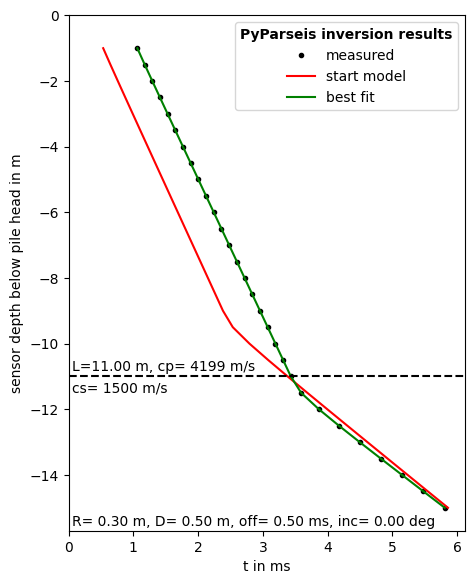

In [12]:
# To do: plot model geometry


cm2inch=1/2.54
fig = plt.figure(figsize=(13*cm2inch,17*cm2inch))

plt.plot(fat*1000, -z, 'ok', label='measured', markersize=3)
plt.plot(tstart*1000, -z, '-r', label='start model')
plt.plot(tfit*1000, -z, '-g', label='best fit')

xmin, xmax, ymin, ymax = plt.axis()
plt.axis([0, xmax,ymin,0])

plt.xlabel("t in ms")
plt.ylabel("sensor depth below pile head in m")
plt.legend(title='PyParseis inversion results',title_fontproperties={'weight':'bold'})
plt.plot([0,xmax],[-fitresultx[2],-fitresultx[2]],ls='--', marker='', color ='k')
plt.text(xmax/100, -fitresultx[2]-ymin*0.01, 'L=%5.2f m, cp=%5.0f m/s' % (fitresultx[2], fitresultx[0]))
plt.text(xmax/100, -fitresultx[2]+ymin*0.03, 'cs=%5.0f m/s' % (fitresultx[1]))
plt.text(xmax/100, ymin*0.99, 'R=%5.2f m, D=%5.2f m, off=%5.2f ms, inc=%5.2f deg' % (R,D,fitresultx[3]*1000,par[4]))
plt.savefig('parseis-fit.png', dpi = 300)
plt.show()
plt.close()

# The end 

In [5]:
#  The end